In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
data=pd.read_csv("dataset.csv")

In [3]:
X = data[['AccuracyPercent', 'AvgReactionTimeSec']]

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

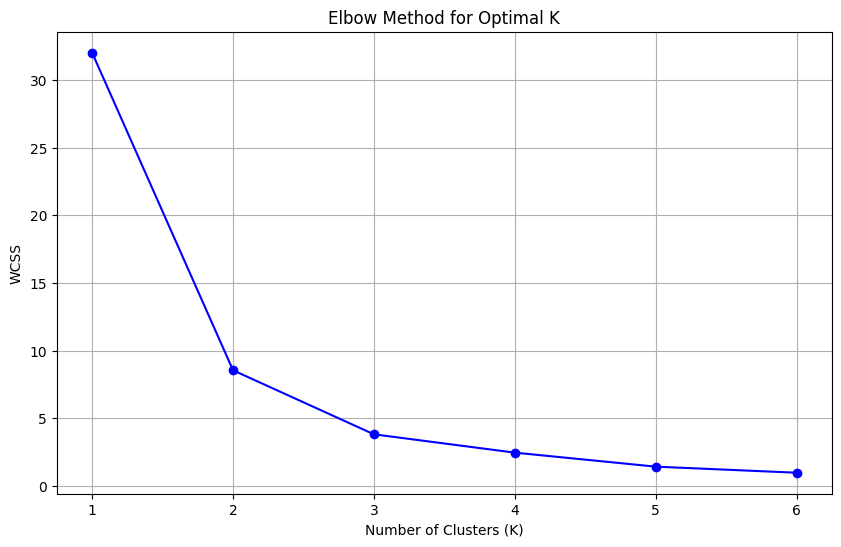

In [5]:
wcss = []  # Within-Cluster Sum of Squares
k_range = range(1, 7)  # Test K=1 to 6

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10,6))
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [6]:
# Initialize with optimal K (example: K=2)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original data
data['Cluster'] = clusters

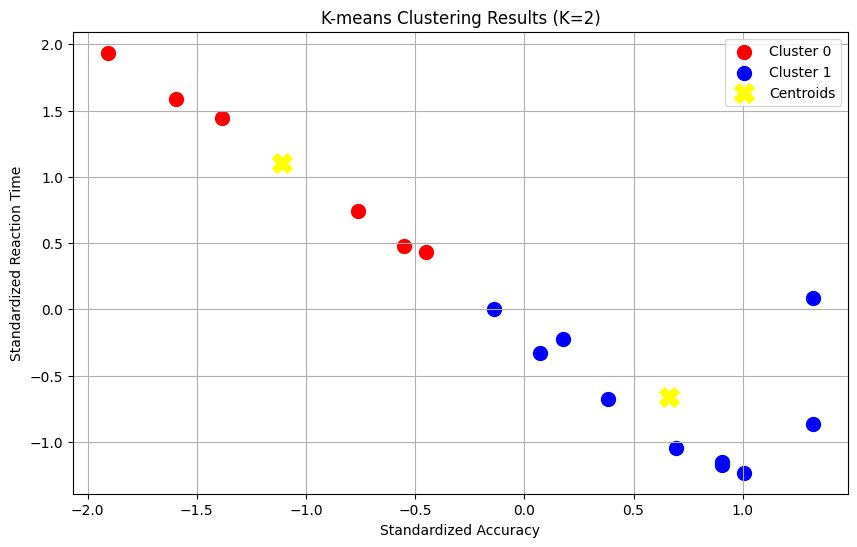

In [7]:
plt.figure(figsize=(10,6))
colors = ['red', 'blue', 'green', 'purple']

# Plot each cluster
for i in range(optimal_k):
    plt.scatter(
        X_scaled[clusters == i, 0],  # Accuracy
        X_scaled[clusters == i, 1],  # Reaction Time
        s=100, c=colors[i],
        label=f'Cluster {i}'
    )

# Plot centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200, c='yellow', marker='X',
    label='Centroids'
)

plt.xlabel('Standardized Accuracy')
plt.ylabel('Standardized Reaction Time')
plt.title('K-means Clustering Results (K=2)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Interpret clusters
cluster_profiles = data.groupby('Cluster')[['AccuracyPercent', 'AvgReactionTimeSec']].mean()
print("Cluster Profiles:")
print(cluster_profiles)



Cluster Profiles:
         AccuracyPercent  AvgReactionTimeSec
Cluster                                     
0              75.666667               2.515
1              92.700000               1.658


In [9]:
# Map clusters to meaningful labels (customize based on your interpretation)
label_map = {0: 'High_Performance', 1: 'Low_Performance'}
data['Performance_Label'] = data['Cluster'].map(label_map)

# Save processed data
data.to_csv('labeled_stroop_data.csv', index=False)

In [10]:
from sklearn.model_selection import train_test_split

# Load K-means labeled data
data = pd.read_csv('labeled_stroop_data.csv')  # Contains 'Cluster' column

# Features and target
X = data[['AccuracyPercent', 'AvgReactionTimeSec']]
y = data['Cluster']  # Cluster labels from K-means

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
from sklearn.svm import SVC

# Scale features (critical for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

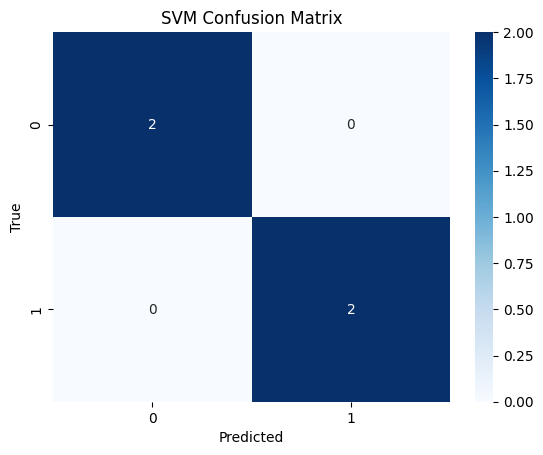

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predictions
y_pred_svm = svm.predict(X_test_scaled)

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

# Classification Report
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Initialize and train Decision Tree
dt = DecisionTreeClassifier(
    max_depth=3,  # Limit depth for interpretability
    min_samples_split=5,
    random_state=42
)
dt.fit(X_train, y_train)  # No scaling needed for trees

DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)

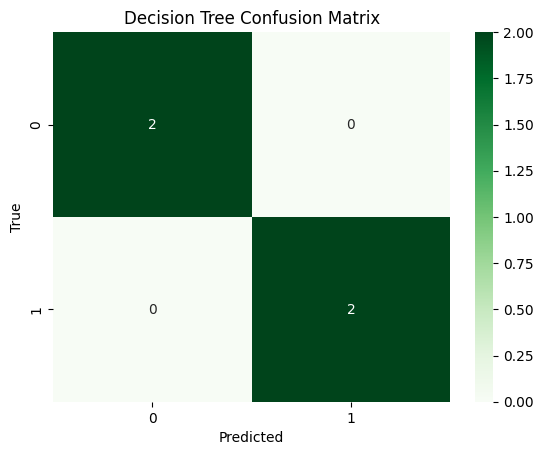

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [14]:
# Predictions
y_pred_dt = dt.predict(X_test)

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=dt.classes_, yticklabels=dt.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Classification Report
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

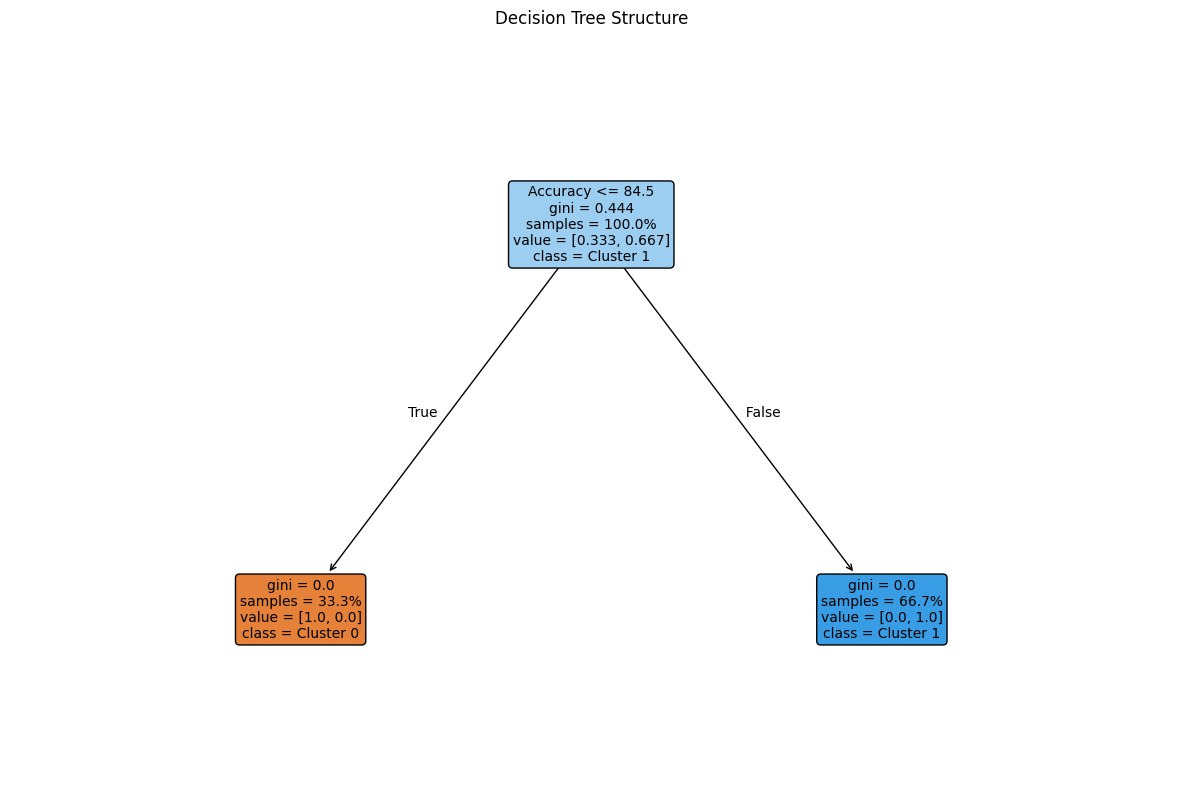

In [15]:
plt.figure(figsize=(15,10))
plot_tree(
    dt,
    feature_names=['Accuracy', 'Avg_Reaction_Time'],
    class_names=[f'Cluster {i}' for i in dt.classes_],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10
)
plt.title('Decision Tree Structure')
plt.show()